# COSC440 Project Part 2: Building a Convolutional Autoencoder

In the first part of the project, we will be introducing and getting familiar with the concept of convolutional autoencoders. In the second part we will apply this model to a domain problem data set. In the final part you will extend the model to address a subproblem in the area of your choice.

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.


<!-- ![Autoencoders](https://drive.google.com/uc?export=view&id=18iU9_yZfqs2QlTPbaibzkMtdIekLuPj2) -->

As we can see, the autoencoder is divided roughly in two parts: the encoder that encodes the input to a "code", or internal representation, that is reduced in dimensions, and the decoder that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function h(x)≈x. In other words, it is trying to learn an approximation to the identity function, so as to output x'  that is similar to x. This may sound like a pretty trivial task, why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### In this part, we will be building a denoising autoencoder. The input of the autoencoder will be a noisy version of our training data and we will train the model to predict the noise free version. 

## Deconvolution (Transposed-Convolution)
Conceptually, deconvolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while deconvolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2 *going from bigger to smaller*:
<!-- ![convolution.gif](https://drive.google.com/uc?export=view&id=1TjSgMinNQ629TrdEmcVjKuwWZ9MGMfg7) -->

#### Deconvolution (convolution with fractional stride) *going from smaller to bigger*:
<!-- ![deconvolution.gif](https://drive.google.com/uc?export=view&id=1opzIaiShA5_nLT5Y5Kh_GqPT9IlVeQF5) -->

As we can see, deconvolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.
Concretely, this is how we implement deconvolution in tensorflow:

``` Python
tf.nn.conv2d_transpose(
    value, # input tensor: A 4-D Tensor of type float and shape [batch, height, width, in_channels]
    filter, # filter tensor: A 4-D Tensor with shape [height, width, output_channels, in_channels]
    output_shape, # A 1-D Tensor representing the output shape of the deconvolution op.
    strides, # A list of ints. The stride of the sliding window for each dimension of the input tensor.
    padding='SAME'
)
```

If set up correctly, you should see "GPU Available: True" in the output.

## Architecture Definition
We want to construct the following architecture:

(Due to the limitations of the rendering engine I'm using, there is a small inaccuracy: the connections in the decoder *{the red prisms}* should be upscaling, not downscaling like in the encoder. - original creator of lab)

Shapes:

Layer | Shape of Output
--- | ---
Input | (batch_size, 28, 28, 1)
encoder_conv_1    | (batch_size, 14, 14, 10)
encoder_conv_2    | (batch_size, 7, 7, 10)  
encoder_conv_3    | (batch_size, 4, 4, 10)  
decoder_deconv_1  | (batch_size, 7, 7, 10)  
decoder_deconv_2  | (batch_size, 14, 14, 10)
decoder_deconv_3  | (batch_size, 28, 28, 1)

<!-- ![Architecture](https://drive.google.com/uc?export=view&id=1GaQ-xZ0lmU8iNTm1IVPo60NyKUAyB9bx) -->

## Setup

Enabling the GPU:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [1]:
# This makes sure that we are using Tensorflow 2
try:
    # Note: %tensorflow_version only exists in Google Colab
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2021-10-19 18:24:16.341953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 18:24:16.342003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.0
GPU Available:  []


2021-10-19 18:24:19.725626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-19 18:24:19.725676: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-19 18:24:19.725729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mint): /proc/driver/nvidia/version does not exist


## Classes
### **Noise**
In order to test our autoencoder, we need to add some noise to our MNIST data points. The goal for the autoencoder is to learn the important underlying features (the numbers) of the data and to ignore the extra noise. 

### **Encoder**
Let's first build the encoding portion of our autoencoder. We're going to directly use Keras layers to help us out by subclassing the Layer class. See this for more information on subclassing Layers: https://www.tensorflow.org/guide/keras/custom_layers_and_models

This should have 3 convolution layers. The layers should be initialized with random normal with standard deviation of 0.1. Also, please use an activation layer of leaky_relu with alpha=0.2. Use a kernel size of 3 and padding of same. Think about what the filter count and stride should be by looking at the output shapes of the architecture.

### **Decoder**
Now let's build the decoder portion of our autoencoder.

This should have 3 deconvolution layers. For the first deconvolution layer please use tf.nn.conv2d_transpose to implement the deconvolution. The other two may be keras layers (Conv2DTranspose). Use the same kernel / activation /initialization as the encoder.

### **AutoEncoder**
Our loss equation is:
$$\sum (y - x)^2$$


y: the encoded image 

x: the original corrupted image (note: **NOT** the original uncorrupted image -- in general it is acceptable to train against the uncorrupted image but that makes an assumption we do not have in the second part of the project, namely that it requires clean images and that the systemic/instrument noise in real data matches the simulated noise function of the training otherwise the trained network risks injecting bias towards the trained noise pattern)

In [2]:
class Noise:
    @staticmethod
    def no_noise(x):
        """This function adds no noise, we use this as a way of comparing the autoencoder when there's no input noise"""
        x = tf.dtypes.cast(x, tf.float32)
        return x

    @staticmethod
    def random_noise(x):
        """This function should add a random uniform tensor of the shape of x between -0.3 to 0.3 to x and then clip it between 0 and 1."""
        x = tf.dtypes.cast(x, tf.float32)
        noised = x + tf.random.uniform(x.shape, minval=-0.3, maxval=0.3)
        return tf.clip_by_value(noised, 0, 1)

    @staticmethod
    def random_scale(x):
        """This function should multiply a random uniform tensor of the shape of x between 0 to 2.0 to x and then clip it between 0 and 1."""
        x_float = tf.dtypes.cast(x, tf.float32)
        noised = tf.math.multiply(x_float, tf.random.uniform(x_float.shape, minval=0.0, maxval=2.0))
        return tf.clip_by_value(noised, 0, 1)


class Encoder(tf.keras.layers.Layer):
    def __init__(self):
       super(Encoder, self).__init__()
       initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
       self.encoder_conv_1 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
       self.encoder_conv_2 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
       self.encoder_conv_3 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
    
    @tf.function
    def call(self, images):
        for layer in [self.encoder_conv_1, self.encoder_conv_2, self.encoder_conv_3]:
            images = layer(images)
            images = tf.nn.leaky_relu(images, 0.2)
        return images


class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
        
        self.L1_W = tf.Variable(tf.random.normal([4, 4, 10, 10], dtype=tf.float32, stddev=0.1))
        self.L1_b = tf.Variable(tf.random.truncated_normal([1, 7, 7, 10], dtype=tf.float32, stddev=0.1))

        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(1, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
        
    @tf.function
    def call(self, encoder_output):
        output_shape = (encoder_output.shape[0], 7, 7, 10)

        deconv_1 = tf.nn.conv2d_transpose(encoder_output, self.L1_W, output_shape, 2)
        deconv_1_with_bias = tf.add(deconv_1, self.L1_b)
        deconv_1_activated = tf.nn.leaky_relu(deconv_1_with_bias, alpha=0.2)
        
        deconv_2 = self.decoder_deconv_2(deconv_1_activated)
        deconv_2_activated = tf.nn.leaky_relu(deconv_2, alpha=0.2)

        deconv_3 = self.decoder_deconv_3(deconv_2_activated)
        deconv_3_activated = tf.nn.leaky_relu(deconv_3, alpha=0.2)

        return deconv_3_activated


class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, images):
        z = self.encoder.call(images)
        return self.decoder.call(z)
    
    @tf.function
    def loss_function(self, encoded, originals):
        encoded = tf.dtypes.cast(encoded, tf.float32)
        originals = tf.dtypes.cast(originals, tf.float32)
        return tf.math.reduce_sum(tf.math.square(encoded - originals))


    def train(self, optimizer, images, noise_function):
        """Train loop for training"""
        corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
    
        with tf.GradientTape() as tape:
            encoded = self.call(corrupted)
            loss = self.loss_function(encoded, corrupted)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def total_loss(self, images, noise_function):
        """This function that calculates the total loss over the entire data set, we use this to track the loss over each epoch"""
        sum_loss = 0
        corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
        predictions = self.call(corrupted)
        sum_loss += model.loss_function(predictions, corrupted).numpy()
        return sum_loss

In [3]:
# Test code for testing autoencoder

# This code is helper code to plot the mnist digits so you
# can see your autoencoder in action!
import matplotlib.pyplot as plt
%matplotlib inline

n_examples = 10
batch_size = 100
n_epochs = 5

mnist = tf.keras.datasets.mnist

(train_images, _), (test_images, _) = mnist.load_data()
test_images = test_images / 255
example_images = test_images[:n_examples]
train_images = train_images / 255

"""Test the convolutional autoencder using MNIST."""


def showImages(model, noise_function):

    corrupted = tf.reshape(noise_function(example_images), [-1, 28, 28, 1])
    recon = model(corrupted)

    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(
                np.reshape(corrupted[example_i, ...], (784,)),
                (28, 28)))
        axs[1][example_i].imshow(
            np.reshape(
                np.reshape(recon[example_i, ...], (784,)),
                (28, 28)))
    plt.show()


# Runs the autoencoder
# Run for each noise function
for noise_function in [Noise.no_noise, Noise.random_scale, Noise.random_noise]:
    print("Showing autoencoder for noise function: {0}".format(noise_function))
    model = AutoEncoder()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    for i in range(n_epochs):
        for j in range(0, len(train_images), batch_size):
            model.train(
                optimizer, train_images[j:j+batch_size], noise_function)

        print("Epoch: ", i)
        sum_loss = model.total_loss(test_images, noise_function)
        print("Total Loss: {0}".format(sum_loss))
        showImages(model, noise_function)

Showing autoencoder for noise function: <function Noise.no_noise at 0x7f4551c244c0>


2021-10-19 18:24:29.097222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-19 18:24:29.920768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KeyboardInterrupt: 

## Checkpoint! 

Check to see if your denoiser works! If it works, you should see the autoencoder images remove noise from the original inputs. The top row for each epoch is the input image and the bottom is the autoencoded image. 

Check out how the different noise functions are handled by the autoencoder.

## Visualizing the Data Representation

We can now visualize where MNIST data points are positioned in the lower dimensional vector space created by the autoencoder (this is similar to the visualization in lecture). Run the following cell to view a 2 dimensional projection of this vector space, where each color represents a different MNIST digit. Notice how even though the dimensionality of this space is much lower than the original (160 vs 784), relevant information about the digits is preserved.

In [ ]:
from sklearn.manifold import TSNE

NUM_SAMPLES = 1000

(_, _),(t_images,t_labels) = mnist.load_data()
t_images = t_images[:NUM_SAMPLES]
t_labels = t_labels[:NUM_SAMPLES]
t_images = t_images / 255

z = model.encoder(tf.reshape(random_noise(t_images), [-1, 28, 28, 1]))
z = np.reshape(z, [NUM_SAMPLES, -1])

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(z)
colors = t_labels
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
plt.colorbar()
plt.show()

## Part 2

In [4]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
lk.log.setLevel('INFO')
tpf = lk.search_targetpixelfile('HAT-P-11', sector=14, cadence='short').download()

5% (913/19337) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [6]:
#plot some initial data
times=tpf.time #astropy_time.iso

print(times[0],"to",times[-1])
print(tpf.flux.shape)
# print("first frame")
# tpf.plot(frame=0)
# print("last frame")
# tpf.plot(frame=tpf.flux.shape[0]-1);

1683.3560021628925 to 1710.2062137662053
(18424, 11, 11)


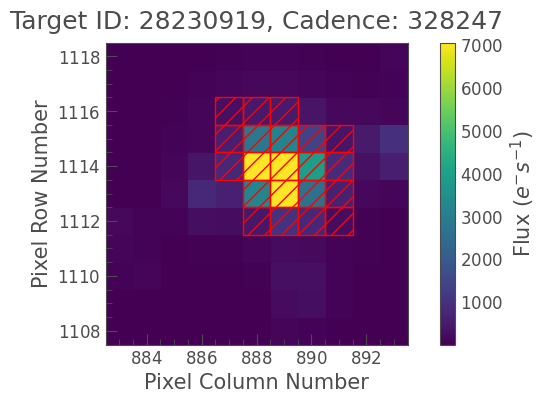

In [4]:
# Apeture Mask
tpf.plot(frame=0, aperture_mask=tpf.pipeline_mask, mask_color='red');

In [7]:
from transitleastsquares import transitleastsquares


def fit_model(lc):
    pg = lc.to_periodogram(method='bls', duration=0.2, minimum_period=1.0)
    pg.plot()
    lc.fold(pg.period_at_max_power).scatter()
    print(pg.period_at_max_power.value)

    model = transitleastsquares(lc.time.value, lc.flux.value)
    results = model.power(period_min=pg.period_at_max_power.value *
                          0.9, period_max=pg.period_at_max_power.value*1.1)
    results.CDPP = lc.estimate_cdpp()
    return results


def plot_results(results):
    plt.figure()
    ax = plt.gca()
    ax.axvline(results.period, alpha=0.4, lw=3)
    plt.xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel(r'SDE')
    plt.xlabel('Period (days)')
    plt.plot(results.periods, results.power, color='black', lw=0.5)
    plt.xlim(0, max(results.periods))


def print_results(results):
    print('Period', format(results.period, '.5f'), 'd')
    print(len(results.transit_times), 'transit times in time series:',
          ['{0:0.5f}'.format(i) for i in results.transit_times])
    print('Transit depth', format(results.depth, '.5f'))
    print('Transit duration (days)', format(results.duration, '.5f'))
    print('SNR', results.snr)
    print('chi2', results.chi2_min)
    print('CDPP', results.CDPP)


def plot_result_fit(results):
    plt.figure()
    plt.plot(results.model_folded_phase,
             results.model_folded_model, color='red')
    plt.scatter(results.folded_phase, results.folded_y,
                color='blue', s=10, alpha=0.5, zorder=2)
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')


def fit_and_report(lc):
    results = fit_model(lc)
    print_results(results)
    plot_results(results)
    plot_result_fit(results)


In [ ]:
#use the provided aperture mask to generate a light curve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask);
lc.plot();

# flatten (detrend) the lightcurve to show relative change using window of 1 day
samples_per_day = 1 + 60 * 24 // 2;
flat_lc = lc.flatten(samples_per_day);
flat_lc.plot();
fit_and_report(flat_lc);

Error: Kernel is dead

In [ ]:
tess_lc = lk.search_lightcurve('HAT-P-11', sector=14, cadence='short').download()
tess_lc.plot(column='sap_flux');
tess_lc.plot(column='flux');
flat_tess_lc = tess_lc.flatten(samples_per_day)
flat_tess_lc.plot();
fit_and_report(flat_tess_lc)

Error: Kernel is dead